# **Core Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our core stock data, scaling and performing PCA (Principle Component Analysis) as well as set up lag and rolling windows.  We will also create new features to help our forthcoming baseline models in the upcoming notebooks.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_data.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
core_stock_data.head()

,Close,Volume,Open,High,Low,SMA_core,EMA_core,RSI_core,Ticker
Date,,,,,,,,,
2019-03-14,45.932499,94318000,45.974998,46.025002,45.639999,41.35925,42.219051,75.741602,AAPL
2019-03-15,46.529999,156171600,46.212502,46.832500,45.935001,41.50025,42.388107,76.985910,AAPL
2019-03-18,47.005001,104879200,46.450001,47.097500,46.447498,41.72940,42.569162,78.724282,AAPL
2019-03-19,46.632500,126585600,47.087502,47.247501,46.480000,41.92075,42.728509,73.527018,AAPL
2019-03-20,47.040001,124140800,46.557499,47.372501,46.182499,42.12190,42.897587,80.396901,AAPL


#### First we will create new custom features for our core data, as well as set up the lag windows and features here.

In [3]:
# Let's create the RMA (Relative Moving Average) to add to our core data.
core_stock_data['RMA_core'] = core_stock_data['Close'] / core_stock_data['EMA_core']

# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Close', 'EMA_core', 'SMA_core', 'RMA_core']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        core_stock_data[f'{feature}_Lag_{lag}'] = core_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
core_stock_data['EMA_Lag_Avg_1_3'] = core_stock_data[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].mean(axis = 1)
core_stock_data['EMA_Lag_Std_1_3'] = core_stock_data[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].std(axis = 1)

core_stock_data['SMA_Lag_Avg_1_3'] = core_stock_data[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].mean(axis = 1)
core_stock_data['SMA_Lag_Std_1_3'] = core_stock_data[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].std(axis = 1)

core_stock_data['RMA_Lag_Avg_1_3'] = core_stock_data[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].mean(axis = 1)
core_stock_data['RMA_Lag_Std_1_3'] = core_stock_data[['RMA_core_Lag_1', 'RMA_core_Lag_2', 'RMA_core_Lag_3']].std(axis = 1)

core_stock_data['Close_Lag_Avg_1_3'] = core_stock_data[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']].mean(axis = 1)
core_stock_data['Close_Lag_Std_1_3'] = core_stock_data[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']].std(axis = 1)

core_stock_data['Diff_Close_EMA_core'] = core_stock_data['Close'] - core_stock_data['EMA_core']
core_stock_data['Ratio_Close_EMA_core'] = core_stock_data['Close'] / core_stock_data['EMA_core']

#print(core_stock_data.head(10))
print(core_stock_data.isnull().sum())


Close                   0
Volume                  0
Open                    0
High                    0
Low                     0
SMA_core                0
EMA_core                0
RSI_core                0
Ticker                  0
RMA_core                0
Close_Lag_1             1
Close_Lag_2             2
Close_Lag_3             3
EMA_core_Lag_1          1
EMA_core_Lag_2          2
EMA_core_Lag_3          3
SMA_core_Lag_1          1
SMA_core_Lag_2          2
SMA_core_Lag_3          3
RMA_core_Lag_1          1
RMA_core_Lag_2          2
RMA_core_Lag_3          3
EMA_Lag_Avg_1_3         1
EMA_Lag_Std_1_3         2
SMA_Lag_Avg_1_3         1
SMA_Lag_Std_1_3         2
RMA_Lag_Avg_1_3         1
RMA_Lag_Std_1_3         2
Close_Lag_Avg_1_3       1
Close_Lag_Std_1_3       2
Diff_Close_EMA_core     0
Ratio_Close_EMA_core    0
dtype: int64


#### Looks like with the creation of our new features we have some missing values to take care of.  Let's address those real quick before we move on.

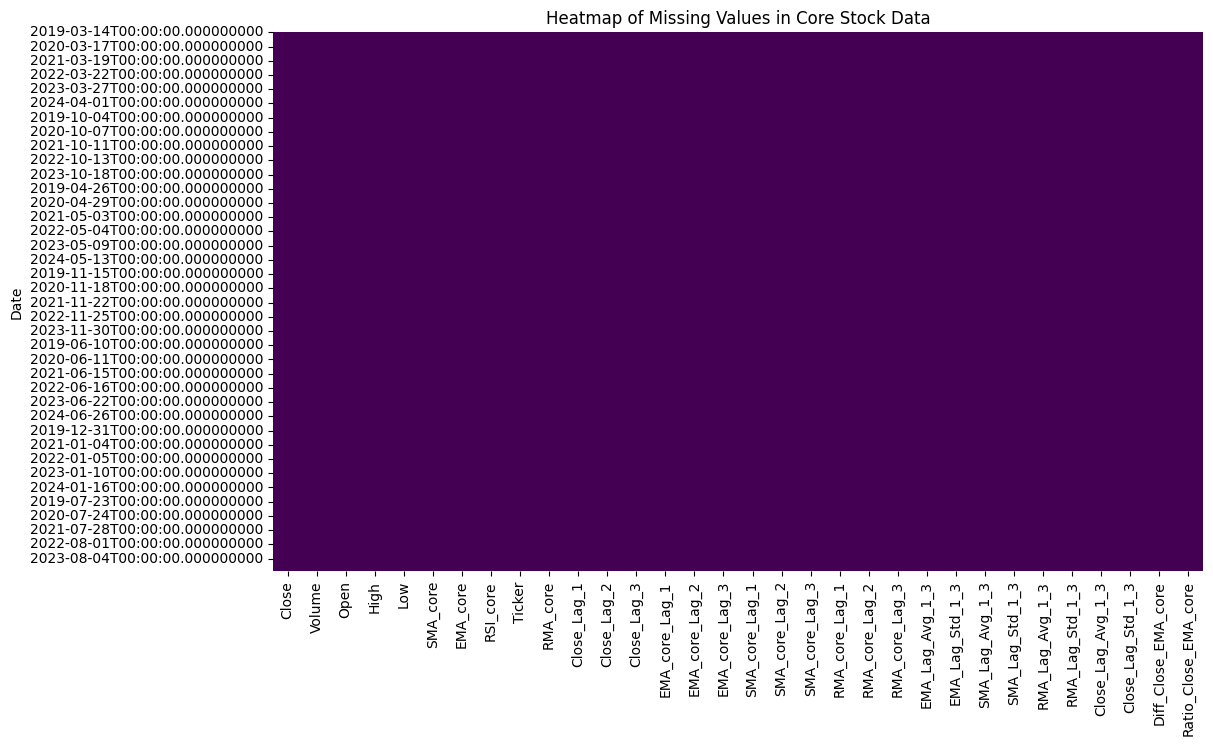

In [4]:
plt.figure(figsize = (12,7))
sns.heatmap(core_stock_data.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

#### There are only a few values to fill, most likely due to the overlapping of the lag windows.  Let's create a quick function to impute those values, and then fill each feature column that contained one.  We will follow with a quick check to see that there are no more remaining missing values.

In [5]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

core_stock_data['Close_Lag_1'] = fill_missing_vals(core_stock_data['Close_Lag_1'])
core_stock_data['Close_Lag_2'] = fill_missing_vals(core_stock_data['Close_Lag_2'])
core_stock_data['Close_Lag_3'] = fill_missing_vals(core_stock_data['Close_Lag_3'])
core_stock_data['EMA_core_Lag_1'] = fill_missing_vals(core_stock_data['EMA_core_Lag_1'])
core_stock_data['EMA_core_Lag_2'] = fill_missing_vals(core_stock_data['EMA_core_Lag_2'])
core_stock_data['EMA_core_Lag_3'] = fill_missing_vals(core_stock_data['EMA_core_Lag_3'])
core_stock_data['SMA_core_Lag_1'] = fill_missing_vals(core_stock_data['SMA_core_Lag_1'])
core_stock_data['SMA_core_Lag_2'] = fill_missing_vals(core_stock_data['SMA_core_Lag_2'])
core_stock_data['SMA_core_Lag_3'] = fill_missing_vals(core_stock_data['SMA_core_Lag_3'])
core_stock_data['RMA_core_Lag_1'] = fill_missing_vals(core_stock_data['RMA_core_Lag_1'])
core_stock_data['RMA_core_Lag_2'] = fill_missing_vals(core_stock_data['RMA_core_Lag_2'])
core_stock_data['RMA_core_Lag_3'] = fill_missing_vals(core_stock_data['RMA_core_Lag_3'])
core_stock_data['EMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['EMA_Lag_Avg_1_3'])
core_stock_data['EMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['EMA_Lag_Std_1_3'])
core_stock_data['SMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['SMA_Lag_Avg_1_3'])
core_stock_data['SMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['SMA_Lag_Std_1_3'])
core_stock_data['RMA_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['RMA_Lag_Avg_1_3'])
core_stock_data['RMA_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['RMA_Lag_Std_1_3'])
core_stock_data['Close_Lag_Avg_1_3'] = fill_missing_vals(core_stock_data['Close_Lag_Avg_1_3'])
core_stock_data['Close_Lag_Std_1_3'] = fill_missing_vals(core_stock_data['Close_Lag_Std_1_3'])

print(core_stock_data.isna().sum())

Close                   0
Volume                  0
Open                    0
High                    0
Low                     0
SMA_core                0
EMA_core                0
RSI_core                0
Ticker                  0
RMA_core                0
Close_Lag_1             0
Close_Lag_2             0
Close_Lag_3             0
EMA_core_Lag_1          0
EMA_core_Lag_2          0
EMA_core_Lag_3          0
SMA_core_Lag_1          0
SMA_core_Lag_2          0
SMA_core_Lag_3          0
RMA_core_Lag_1          0
RMA_core_Lag_2          0
RMA_core_Lag_3          0
EMA_Lag_Avg_1_3         0
EMA_Lag_Std_1_3         0
SMA_Lag_Avg_1_3         0
SMA_Lag_Std_1_3         0
RMA_Lag_Avg_1_3         0
RMA_Lag_Std_1_3         0
Close_Lag_Avg_1_3       0
Close_Lag_Std_1_3       0
Diff_Close_EMA_core     0
Ratio_Close_EMA_core    0
dtype: int64


# Looks good, now we can move on to scaling our new dataframe.

In [6]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
tickers = core_stock_data['Ticker']
core_stock_data = core_stock_data.drop(columns = ['Ticker'])

# Initiate the scaler and transform the data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(core_stock_data)
core_stock_scaled = pd.DataFrame(scaled_data, index = core_stock_data.index, columns = core_stock_data.columns)
print(core_stock_scaled.head())

               Close    Volume      Open      High       Low  SMA_core  \
Date                                                                     
2019-03-14 -1.013302 -0.074793 -1.012345 -1.018762 -1.009483 -1.085271   
2019-03-15 -1.007093  0.293158 -1.009876 -1.010456 -1.006383 -1.083783   
2019-03-18 -1.002157 -0.011968 -1.007406 -1.007730 -1.000997 -1.081366   
2019-03-19 -1.006028  0.117158 -1.000779 -1.006187 -1.000655 -1.079347   
2019-03-20 -1.001793  0.102615 -1.006289 -1.004901 -1.003782 -1.077225   

            EMA_core  RSI_core  RMA_core  Close_Lag_1  ...  EMA_Lag_Avg_1_3  \
Date                                                   ...                    
2019-03-14 -1.049825  1.249108  0.801504    -1.013494  ...        -1.050817   
2019-03-15 -1.048013  1.325622  0.931542    -1.013494  ...        -1.050817   
2019-03-18 -1.046072  1.432516  1.018034    -1.007280  ...        -1.049909   
2019-03-19 -1.044364  1.112931  0.846961    -1.002341  ...        -1.048958   
2019-03

#### Now we can move on to the last part of our processing, the PCA or Principal Component Analysis.  Here we will look at reducing dimensionality of our scaled dataframe and reduce the variance.

In [7]:
# Instantiate the pca variable and transform on our new data.
pca = PCA(n_components = None)
core_pca = pca.fit_transform(core_stock_scaled)

# The variables below are just being set up so we can use them in the following plots.
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

In [10]:
explained_variance_trace = go.Scatter(
    x = list(range(1, len(explained_variance) + 1)),
    y = explained_variance,
    mode = 'lines+markers',
    name = 'Explained Variance',
    line = dict(color = 'blue')
)

cumulative_explained_variance_trace = go.Scatter(
    x = list(range(1, len(cumulative_explained_variance) + 1)),
    y = cumulative_explained_variance,
    mode = 'lines+markers',
    name = 'Cumulative Explained Variance',
    line = dict(color = 'green')
)

variance_threshold_trace = go.Scatter(
    x = [1, len(cumulative_explained_variance)],
    y = [0.95, 0.95],
    mode = 'lines',
    name = '95% Variance Threshold',
    line = dict(color = 'red', dash = 'dash')
)

fig = go.Figure(data = [explained_variance_trace, cumulative_explained_variance_trace, variance_threshold_trace])
fig.update_layout(
    title = 'Explained Variance by Principal Components',
    xaxis_title = 'Number of Components',
    yaxis_title = 'Variance Explained',
    template = 'plotly_dark'    
)

fig.show()